# Agenda

1. Reading the data into a pandas dataframe
2. Exploring the dataset
3. Trying a basic model and see its accuracy

In [1]:
!pip install pyconll
!pip install nltk

In [112]:
import pyconll
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

## 1. Reading the data into a pandas dataframe

In [35]:
file_path = '/kaggle/input/ud-arabic-padt/ar_padt-ud-train.conllu'
dataset = pyconll.load_from_file(file_path)

dev_path= '/kaggle/input/ud-arabic-padt/ar_padt-ud-dev.conllu'
dev_dataset = pyconll.load_from_file(dev_path)

test_path ='/kaggle/input/ud-arabic-padt/ar_padt-ud-test.conllu'
test_dataset = pyconll.load_from_file(test_path)

In [36]:
def get_df(dataset):
    # Initialize lists to store data
    samples = []

    # Iterate over a few sentences to collect samples
    for i, sentence in enumerate(dataset):
        # Initialize lists to store tokens and POS tags for the current sentence
        tokens = []
        pos_tags = []
        # Iterate over tokens in the sentence and collect data
        for token in sentence:
            tokens.append(token.form)
            pos_tags.append(token.upos)
        # Append data for the current sentence as a tuple (word form, POS tag)
        samples.append((tokens, pos_tags))

    # Create a DataFrame from the collected samples
    return pd.DataFrame(samples, columns=['sent', 'pos_tags'])

# Print the Data
df = get_df(dataset)
df.head()

,sent,pos_tags
0,"[برلين, ترفض, حصول, شركة, اميركية, على, رخصة, ...","[X, VERB, NOUN, NOUN, ADJ, ADP, NOUN, NOUN, NO..."
1,"[برلين, 15, -, 7, (, اف, ب, ), -, افادت, صحيفة...","[X, NUM, PUNCT, NUM, PUNCT, X, X, PUNCT, PUNCT..."
2,"[وفي, و, في, نيسان, /, ابريل, الماضي, ،, تخلت,...","[None, CCONJ, ADP, NOUN, PUNCT, NOUN, ADJ, PUN..."
3,"[وكانت, و, كانت, خسائر, المجموعة, الاسبانية, ا...","[None, CCONJ, VERB, NOUN, NOUN, ADJ, ADJ, VERB..."
4,"[واشارت, و, أشارت, صحيفة, الاحد, الى, ان, المس...","[None, CCONJ, VERB, NOUN, NOUN, ADP, SCONJ, NO..."


In [18]:
df.shape

(6075, 2)

In [9]:
df["sent"][0]

['برلين',
 'ترفض',
 'حصول',
 'شركة',
 'اميركية',
 'على',
 'رخصة',
 'تصنيع',
 'دبابة',
 '"',
 'ليوبارد',
 '"',
 'الالمانية']

In [10]:
df["pos_tags"][0]

['X',
 'VERB',
 'NOUN',
 'NOUN',
 'ADJ',
 'ADP',
 'NOUN',
 'NOUN',
 'NOUN',
 'PUNCT',
 'X',
 'PUNCT',
 'ADJ']

In [37]:
dev_df= get_df(dev_dataset)
test_df= get_df(test_dataset)

## 2. Exploring the dataset

In [28]:
# Initialize lists to store data
samples = {}
tokens = []
pos_tags = []
for i, sentence in enumerate(dataset):
    # Iterate over tokens in the sentence and collect data
    for token in sentence:
        tokens.append(token.form)
        pos_tags.append(token.upos)
    # Append data for the current sentence as a tuple (word form, POS tag)
samples["tokens"]=tokens
samples["pos_tags"]=pos_tags

# Create a DataFrame from the collected samples
df2 = pd.DataFrame(samples)

# Print the Data
df2.head()

,tokens,pos_tags
0,برلين,X
1,ترفض,VERB
2,حصول,NOUN
3,شركة,NOUN
4,اميركية,ADJ


In [20]:
df2.shape

(254384, 2)

In [21]:
df2.describe()

,tokens,pos_tags
count,254384,223899
unique,33496,17
top,و,NOUN
freq,12982,74546


In [30]:
df2.pos_tags.value_counts()

pos_tags
NOUN     74546
ADP      33617
ADJ      23498
PUNCT    17511
VERB     16807
CCONJ    15803
X        13747
PRON      8533
NUM       6010
DET       4648
SCONJ     4368
PART      1709
AUX       1699
ADV        880
SYM        329
PROPN      187
INTJ         7
Name: count, dtype: int64

<Axes: xlabel='pos_tags'>

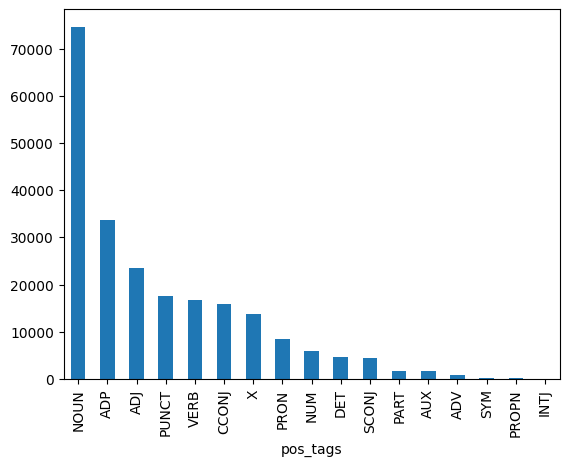

In [31]:
df2['pos_tags'].value_counts().plot.bar()

In [32]:
print(len(df2))

254384


### Can a token have 2 different POS tags?

Short answer: **Yes!**

#### Long answer:

In [41]:
t_d={}
for i in range(len(df2)):
    if df2["tokens"][i] in t_d.keys():
        t_d[df2["tokens"][i]].append(df2["pos_tags"][i])
    else:
        t_d[df2["tokens"][i]]=[]
counter = 20
sum=0
for i in t_d.keys():
    c=len(set(t_d[i]))
    if c>1:
        sum+=1
        if counter>0:
            counter-=1
            print(i,set(t_d[i]))
print("total",sum)

اميركية {'ADJ', 'X'}
على {'X', 'NOUN', 'ADP'}
الالمانية {'ADJ', 'NOUN'}
ب {'X', 'ADP'}
الاحد {'X', 'NOUN'}
ام {'X', 'CCONJ'}
في {'X', 'ADP'}
عدد {'X', 'VERB', 'NOUN'}
ها {'PRON', 'DET', 'PART'}
الصادر {'ADJ', None}
ان {'X', 'SCONJ', 'VERB', 'PART'}
الاميركية {'ADJ', 'X', 'NOUN'}
جنرال {'X', 'NOUN'}
ل {'X', 'CCONJ', 'PART', 'ADP'}
عبر {'VERB', 'ADP'}
الاسبانية {'ADJ', 'X', 'NOUN'}
و {'X', 'CCONJ'}
/ {'PUNCT', 'SYM'}
الماضي {'ADJ', 'NOUN'}
التي {'X', 'DET'}
total 1584


## 3. Modelling

Given the answer for the question above, we defently know that we need a sequential model, but fo the sake of just exploring 

In [33]:
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, SimpleRNN
from tensorflow.keras.models import Sequential

### Pre-Processing

In [122]:
def get_numbers(df):
    # Convert tokens and POS tags to numeric representation
    vocab = set([word for sentence in df["sent"] for word in sentence])
    pos_tag_set = set([tag for tags in df["pos_tags"] for tag in tags])

    word2idx = {w: i + 1 for i, w in enumerate(vocab)}
    pos2idx = {t: i for i, t in enumerate(pos_tag_set)}
    idx2pos = {i: t for i, t in enumerate(pos_tag_set)}

    return [[word2idx[token] for token in sentence] for sentence in df["sent"]],\
           [[pos2idx[tag] for tag in tags] for tags in df["pos_tags"]], vocab, pos_tag_set

In [123]:
X, Y, vocab, pos_tag_set = get_numbers(df)
dev_X, dev_Y, _, _ = get_numbers(dev_df)
test_X, test_Y, _, _ = get_numbers(test_df)

In [121]:
X[0], Y[0]

([22524,
  24035,
  26289,
  15088,
  31118,
  6582,
  25653,
  24494,
  5102,
  21204,
  26703,
  21204,
  20759],
 [14, 1, 17, 17, 15, 12, 17, 17, 17, 5, 14, 5, 15])

#### Determine the length of the longest sentence

In [118]:
# Pad sequences to have same length
max_len=478

X_padded =pad_sequences(X, maxlen=max_len, padding='post')
Y_padded =pad_sequences(Y, maxlen=max_len, padding='post')

dev_X_padded=pad_sequences(dev_X, maxlen=max_len, padding='post')
dev_Y_padded = pad_sequences(dev_Y, maxlen=max_len, padding='post')

test_X_padded=pad_sequences(test_X, maxlen=max_len, padding='post') 
test_Y_padded=pad_sequences(test_Y, maxlen=max_len, padding='post')

In [ ]:
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)

### RNN

In [119]:
# Build RNN model
model = Sequential([
        Embedding(input_dim=len(vocab) + 1, output_dim=8),
        SimpleRNN(16, return_sequences=True),
        TimeDistributed(Dense(len(pos_tag_set), activation='softmax'))
    ])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Train model
history = model.fit(X_padded, Y_padded, epochs=2, batch_size=64)

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_34 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_32             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/2
95/95 ━━━━━━━━━━━━━━━━━━━━ 69s 384ms/step - accuracy: 0.6837 - loss: 1.5193
Epoch 2/2
95/95 ━━━━━━━━━━━━━━━━━━━━ 36s 383ms/step - accuracy: 0.9253 - loss: 0.3419


In [120]:
evaluate_model(model, dev_X_padded, dev_Y_padded)
evaluate_model(model, test_X_padded, test_Y_padded)

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9300 - loss: 0.2637
Test Loss: 0.2715582847595215
Test Accuracy: 0.9275584816932678
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8999 - loss: 0.3617
Test Loss: 0.3338169455528259
Test Accuracy: 0.9090051054954529


### LSTM

I tried simple LSTM models with variant hyper-parameters -including #nodes, batch_size, and #epochs- and  the best that I got was 79.69% training accuracy 81.92% dev accuracy and 69.09% test accuracy<br>
I tried the same simple LSTM models with variant hyper-parameters and the best that I got was 91.58% training accuracy 92.39% dev accuracy and 90.46% test accuracy.<br> 
The only difference between the first batch of experiments and the second ones was the `maxlen` provided to the `pad_sequences` function, as in the first no.of experiments `maxlen = 150` and in the second batch of experiments  `maxlen = 478` where 478 is the length of the biggest sequence in the training dataset.

In [115]:
# Build LSTM model
model = Sequential([
        Embedding(input_dim=len(vocab) + 1, output_dim=16),
        LSTM(32, return_sequences=True),
        TimeDistributed(Dense(len(pos_tag_set), activation='softmax'))
    ])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Train model
history = model.fit(X_padded, Y_padded, epochs=2, batch_size=64)

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_33 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_31             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/2
95/95 ━━━━━━━━━━━━━━━━━━━━ 118s 772ms/step - accuracy: 0.8690 - loss: 1.0007
Epoch 2/2
95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 784ms/step - accuracy: 0.9376 - loss: 0.2432


In [116]:
evaluate_model(model, dev_X_padded, dev_Y_padded)
evaluate_model(model, test_X_padded, test_Y_padded)

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.9447 - loss: 0.2071
Test Loss: 0.2140791416168213
Test Accuracy: 0.9432685375213623
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.8913 - loss: 0.3255
Test Loss: 0.29669979214668274
Test Accuracy: 0.9011475443840027


## Acknowledgements:
1. orginal dataset https://github.com/UniversalDependencies/UD_Arabic-PADT
2. Nada Alswah https://www.kaggle.com/code/nadaalswah/arabic-pos-with-lstm